# Лабораторная работа №3

Вариант: 9 [Датасет про студенов](https://www.kaggle.com/datasets/nikhil7280/student-performance-multiple-linear-regression)

Импортируем необходимые библиотеки

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math

pd.options.mode.chained_assignment = None
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

Для начала загрузим датасет и выведем его

In [2]:
df = pd.read_csv("./data/Student_Performance.csv")
df

,Hours Studied,Previous Scores,Extracurricular Activities,Sleep Hours,Sample Question Papers Practiced,Performance Index
0,7,99,Yes,9,1,91.0
1,4,82,No,4,2,65.0
2,8,51,Yes,7,2,45.0
3,5,52,Yes,5,2,36.0
4,7,75,No,8,5,66.0
...,...,...,...,...,...,...
9995,1,49,Yes,4,2,23.0
9996,7,64,Yes,8,5,58.0
9997,6,83,Yes,8,5,74.0
9998,9,97,Yes,7,0,95.0


Перед тем как приступать к дальнейшей обработке, произведём кодирование категориальных признаков:

- `Extracurricular Activities` -- возможные значения: `{"Yes", "No"}`

In [3]:
df.replace({"Extracurricular Activities": {"Yes": 1, "No": 0}}, inplace=True)

Введём также синтетический признак: `Balance Index`, который будет зависеть от баланса веремени учёбы и сна студента, и вычислятся по формуле:

`Hours Studied` / `Sleep Hours`

Если значение слишком высокое => выгорание

Если низкое => недостаточно времени уделяет учебе

In [4]:
df["Balance Index"] = df["Hours Studied"] / df["Sleep Hours"]

Рассчитаем основные статистические показатели по данным

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 7 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Hours Studied                     10000 non-null  int64  
 1   Previous Scores                   10000 non-null  int64  
 2   Extracurricular Activities        10000 non-null  int64  
 3   Sleep Hours                       10000 non-null  int64  
 4   Sample Question Papers Practiced  10000 non-null  int64  
 5   Performance Index                 10000 non-null  float64
 6   Balance Index                     10000 non-null  float64
dtypes: float64(2), int64(5)
memory usage: 547.0 KB


In [6]:
df.describe()

,Hours Studied,Previous Scores,Extracurricular Activities,Sleep Hours,Sample Question Papers Practiced,Performance Index,Balance Index
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,4.992900,69.445700,0.494800,6.530600,4.583300,55.224800,0.823474
std,2.589309,17.343152,0.499998,1.695863,2.867348,19.212558,0.499870
min,1.000000,40.000000,0.000000,4.000000,0.000000,10.000000,0.111111
25%,3.000000,54.000000,0.000000,5.000000,2.000000,40.000000,0.428571
50%,5.000000,69.000000,0.000000,7.000000,5.000000,55.000000,0.750000
75%,7.000000,85.000000,1.000000,8.000000,7.000000,71.000000,1.142857
max,9.000000,99.000000,1.000000,9.000000,9.000000,100.000000,2.250000


array([[<Axes: title={'center': 'Hours Studied'}>,
        <Axes: title={'center': 'Previous Scores'}>],
       [<Axes: title={'center': 'Sleep Hours'}>,
        <Axes: title={'center': 'Sample Question Papers Practiced'}>],
       [<Axes: title={'center': 'Performance Index'}>,
        <Axes: title={'center': 'Balance Index'}>]], dtype=object)

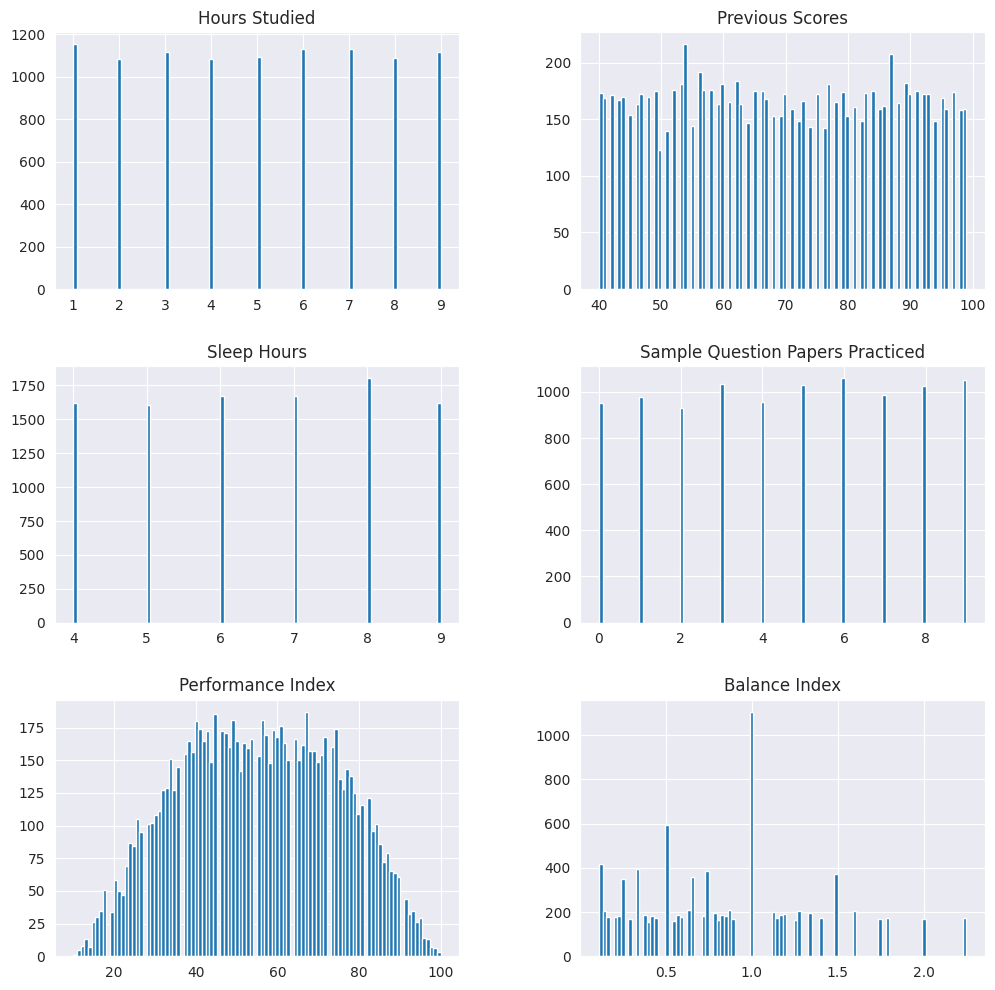

In [7]:
cols = list(df.columns)
cols.remove("Extracurricular Activities")
df[cols].hist(bins=100, figsize=(12, 12))

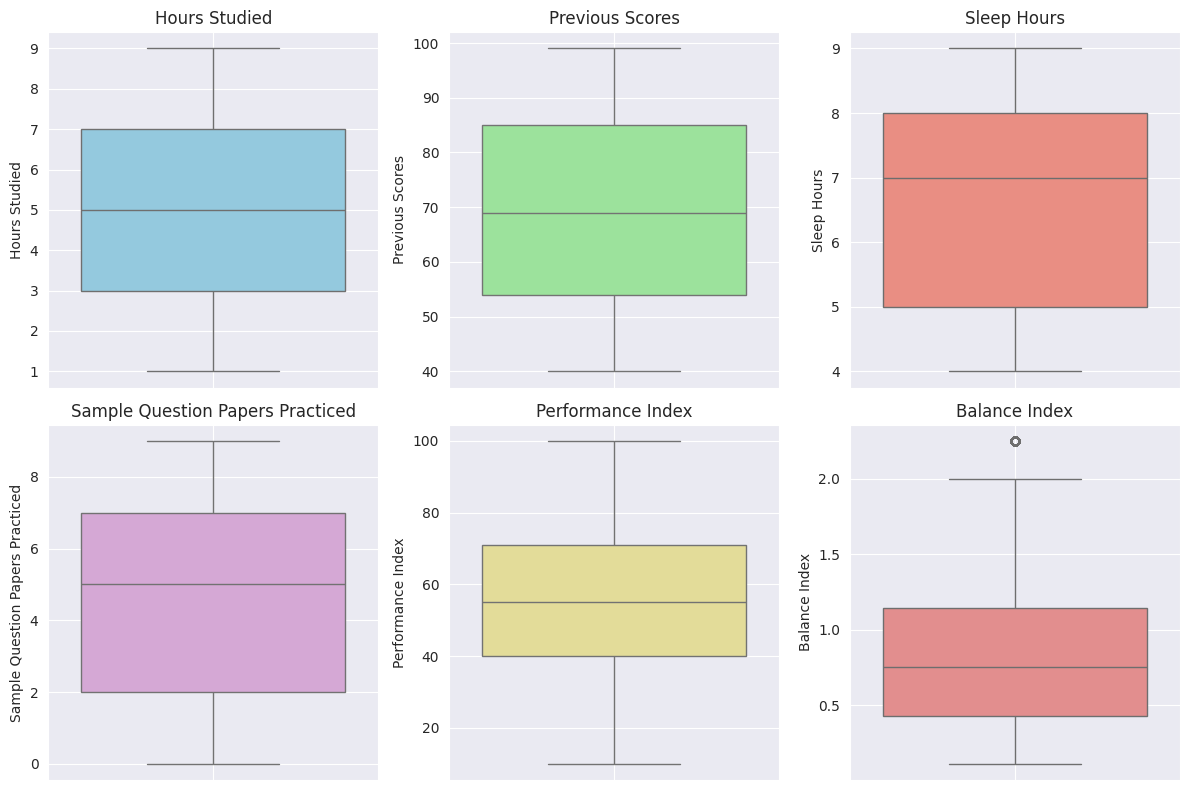

In [8]:
num_cols = len(df.columns)
cols_per_row = 3

fig, axes = plt.subplots(2, cols_per_row, figsize=(12, 8))
axes = axes.flatten() if num_cols > 1 else [axes]

colors = ["skyblue", "lightgreen", "salmon", "plum", "khaki", "lightcoral"]

cols = list(df.columns)
cols.remove("Extracurricular Activities")
for i, col in enumerate(cols):
    sns.boxplot(y=df[col], ax=axes[i], color=colors[i % len(colors)])
    axes[i].set_title(col)
    axes[i].grid(True)

plt.tight_layout()
plt.show()

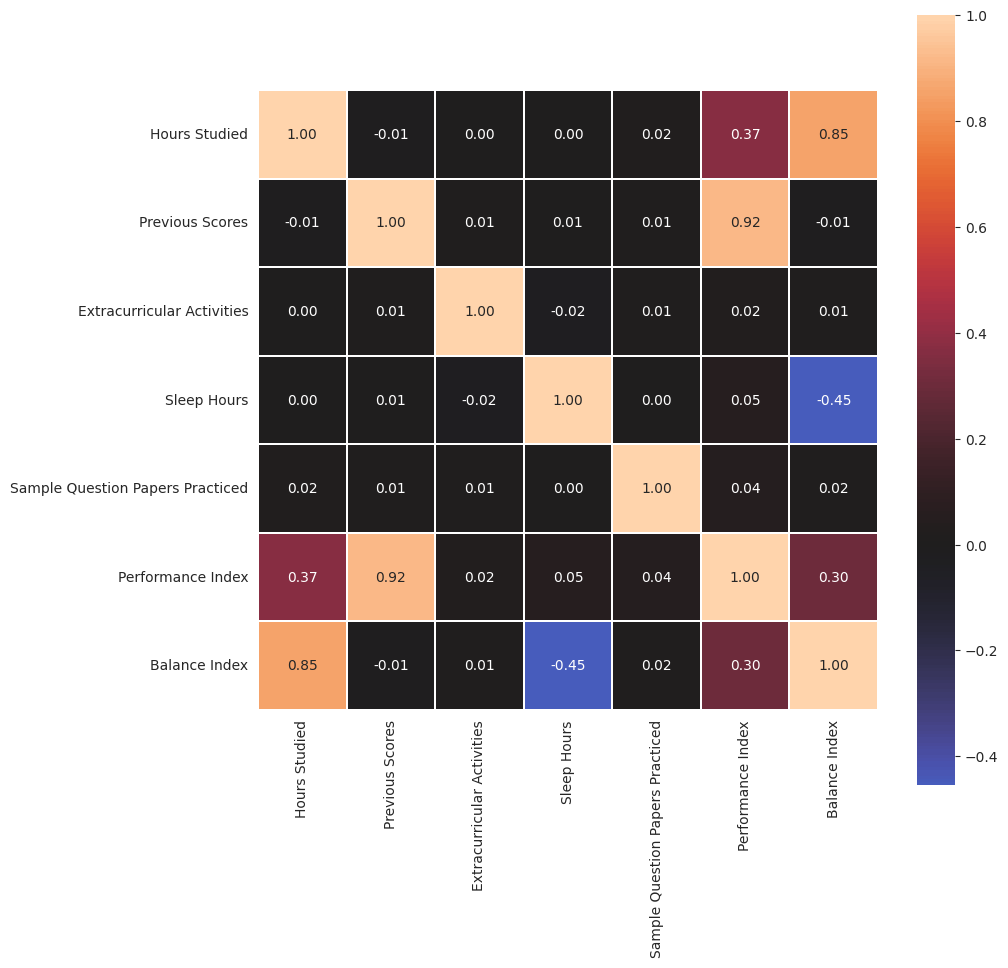

In [9]:
plt.figure(figsize=(10, 10))
sns.heatmap(df.corr(), annot=True, fmt=".2f", center=0,
            square=True, linewidths=0.1)
plt.show()

Заметим, что выявлена сильная корреляция целевого признака `Performance Index` с признаками `Previous Scores`, `Hours Studied` и `Balance Index`

Проанализируем теперь датасет на наличие пропущенных значений

In [10]:
print(df.isnull().sum())

Hours Studied                       0
Previous Scores                     0
Extracurricular Activities          0
Sleep Hours                         0
Sample Question Papers Practiced    0
Performance Index                   0
Balance Index                       0
dtype: int64


Пропущенных значений нет, следовательно заполнять их не нужно

Теперь нормализуем данные с помощью min-max нормализации:

$$
x_{norm} = \frac{x-x_{min}}{x_{max}-x_{min}}
$$

In [11]:
n_df = df.copy()

for col in df:
    min_v = df[col].min()
    max_v = df[col].max()
    if min_v == max_v:
        continue
    n_df[col] = (df[col] - min_v) / (max_v - min_v)

n_df

,Hours Studied,Previous Scores,Extracurricular Activities,Sleep Hours,Sample Question Papers Practiced,Performance Index,Balance Index
0,0.750,1.000000,1.0,1.0,0.111111,0.900000,0.311688
1,0.375,0.711864,0.0,0.0,0.222222,0.611111,0.415584
2,0.875,0.186441,1.0,0.6,0.222222,0.388889,0.482375
3,0.500,0.203390,1.0,0.2,0.222222,0.288889,0.415584
4,0.750,0.593220,0.0,0.8,0.555556,0.622222,0.357143
...,...,...,...,...,...,...,...
9995,0.000,0.152542,1.0,0.0,0.222222,0.144444,0.064935
9996,0.750,0.406780,1.0,0.8,0.555556,0.533333,0.357143
9997,0.625,0.728814,1.0,0.8,0.555556,0.711111,0.298701
9998,1.000,0.966102,1.0,0.6,0.000000,0.944444,0.549165


Разделим данные на тренировочную и тестовую выборки

In [12]:
train = n_df.sample(frac=0.8, random_state=1516)
test = n_df.drop(train.index)

train_x = train.drop('Performance Index', axis=1)
train_y = train['Performance Index']

test_x = test.drop('Performance Index', axis=1)
test_y = test['Performance Index']

Реализуем линейную регрессию

Формула для вычисления коэффициентов имеет вид:

$$
\beta = (X^TX)^{-1}X^Ty_{train}
$$

Предсказание при этом происходит по формуле

$$
y_{pred}=X\beta
$$

In [13]:
def add_ones(x):
        return np.concatenate((np.ones((len(x), 1)), x), axis=1)

def fit(X, y):
    x = add_ones(X)
    beta = (np.linalg.inv(x.T @ x)) @ (x.T @ y)
    return beta

def predict(X, beta):
    x = add_ones(X)
    return x @ beta

Также определим вспомогательную функции для рассчета коэффициента детерминации, которая и будет показателем точности построенной модели

Формула для рассчета:

$$
R^2 = 1 - \frac{SS_{res}}{SS_{tot}}
$$

где $SS_{res}$ - мера ошибки модели (отклонение от реальных значений)

$$
SS_{res} = \sum_i(y_i-\hat{y}_i)^2
$$

а $SS_{tot}$ - отклонение предсказанных значений от среднего

$$
SS_{tot} = \sum_i(y_i-\overline{y}_i)^2
$$

In [14]:
def count_determination(true_y, predicted_y):
    mean_y = np.mean(true_y)
    total_ss = np.sum(np.square(true_y - mean_y))
    residual_ss = np.sum(np.square(true_y - predicted_y))
    return 1 - residual_ss / total_ss

Также введём вспомогательную функцию для тренировки модели на определенных колонках таблицы и вывода коээффициента детерминации

In [15]:
def explore(cols):
    beta = fit(train_x[cols], train_y)
    pred_y = predict(test_x[cols], beta)
    r2 = count_determination(test_y, pred_y)
    print(f"На колонках {cols}\nПолучен коээфициент детерминации: {r2}")

Для начала натренируем модель на всех данных

In [16]:
explore(list(train_x.columns))

На колонках ['Hours Studied', 'Previous Scores', 'Extracurricular Activities', 'Sleep Hours', 'Sample Question Papers Practiced', 'Balance Index']
Получен коээфициент детерминации: 0.9880248768644806


Теперь только на колонке `Previous Scores`

In [17]:
explore(["Previous Scores"])

На колонках ['Previous Scores']
Получен коээфициент детерминации: 0.8393094787606026


Теперь только на колонке `Hours Studied`

In [18]:
explore(["Hours Studied"])

На колонках ['Hours Studied']
Получен коээфициент детерминации: 0.1427592220363747


Теперь только на колонке `Balance Index`

In [19]:
explore(["Balance Index"])

На колонках ['Balance Index']
Получен коээфициент детерминации: 0.09328968089074718


И на всех трёх колонках вместе

In [20]:
explore(["Previous Scores", "Hours Studied", "Balance Index"])

На колонках ['Previous Scores', 'Hours Studied', 'Balance Index']
Получен коээфициент детерминации: 0.9864742452978372


Также попробуем натренировать модель удалив колонки `Previous Scores` и `Hours Studied`

In [21]:
cols = list(train_x.columns)
cols.remove("Previous Scores")
cols.remove("Hours Studied")
cols.remove("Balance Index")
explore(cols)

На колонках ['Extracurricular Activities', 'Sleep Hours', 'Sample Question Papers Practiced']
Получен коээфициент детерминации: 0.0033121751927150944


Из проведённой выше серии проверок можно сделать вывод, что наиболее коррелированные ячеки `Previous Scores` и `Hours Studied` фактически определяют то насколько хорошо модель предсказывает значения. Остальные колонки практически не влияют на результат.

Также можно отметить, что синтетическое свойство, которое я добавил, представляющее собой линейную комбинацию исходных переменных, несущественно повышает предсказательную способность модели, то есть не обеспечивает значительного прироста точности.